Multi Layer perceptron 

In [1]:
import math 
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Value:
    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = _children
        self._op = _op
        self.label = label
    
    def __repr__(self) -> str:
        return f'Value(data = {self.data})'
    
    

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    

    def __pow__(self, other):
        assert isinstance(other, (int,float)) # only support int & float powers for now
        out = Value(self.data**other, (self,), f'^{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    
    
    def __neg__(self):
        return -1 * self
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return self + (-other)
    
    def __radd__(self, other):
        return self + other
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * (other ** -1)
    
    def __rtruediv__(self, other):
        return self * (other ** -1)

    
    def sigmoid(self):
        x = self.data
        s = 1/(1+ math.exp(-x))
        out = Value(s, (self, ), 'sigmoid')

        def _backward():
            self.grad += s * (1-s)

        out._backward = _backward
        
        return out
    
    def relu(self):
        x = self.data
        r = max(x,0)
        out = Value(r, (self, ), 'ReLU')

        def _backward():
            self.grad += 1 if x > 0 else 0

        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def linear(self):
        x = self.data
        out = Value(x, (self, ), 'linear')

        def _backward():
            self.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def ln(self):
        x = self.data
        out = Value(math.log(x), (self, ), 'ln')

        def _backward():
            self.grad += (1/x) * out.grad
        out._backward = _backward
        return out
    

    def backward(self):
        topological = []
        visited = set()

        def build_topological(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topological(child)
                topological.append(v)

        build_topological(self)
        
        self.grad = 1.0
        for node in reversed(topological):
            node._backward()

In [3]:
class Neuron:
    
    def __init__(self, numIn, activation) -> None:
        self.w = [Value(random.uniform(-1,1)) for _ in range(numIn)]
        self.b = Value(random.uniform(-1,1))
        self.act_func = activation
    
    def __call__(self, x):
        # w . x + b
        act = sum(w1*x1 for w1, x1 in zip(self.w, x)) + self.b
        out = getattr(act, self.act_func)()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, numIn, numOut, activation) -> None:
        self.neurons = [Neuron(numIn, activation) for _ in range(numOut)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        params = []
        for neuron in self.neurons:
            params.extend(neuron.parameters())
        return params
    
        
class MLP:
    def __init__(self, numIn, numOuts, activations) -> None:
        sizes = [numIn] + numOuts 
        self.layers = [Layer(sizes[i], sizes[i+1], activations[i]) for i in range(len(numOuts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        params = []
        for layer in self.layers:
            params.extend(layer.parameters())
        return params
        

MNIST DATASET

first element = label 
rest = picture 

In [4]:
import pandas as pd
df = pd.read_csv('mnist_test.csv', header = 0)

ys = df.iloc[:, 0].tolist()  # First column
xs = df.iloc[:, 1:].values.tolist()  # Remaining columns

# xs -> 784-ary arrays 
# ys -> labels  


In [43]:
n = MLP(3, [25, 15, 10], ['relu','relu','linear'])

In [50]:
def softmax(z):
    ez = np.exp(z)
    a = ez/np.sum(ez)
    return a

In [51]:
# Using Categorical cross-entropy loss [with softmax function]



for k in range(50):

    # Forward pass

    ypred = [n(x) for x in xs]

    # y_pd -> probabilities predicted using softmax
    y_pd = softmax(ypred) #softmax probability distribution 

    loss = - sum((y_pd[i][ys[i]]).ln() for i in range(len(xs))) / len(xs)
    
    # Backward pass
    for p in n.parameters():
        p.grad = 0
    loss.backward()

    # Update
    for p in n.parameters():
        p.data += -0.5 * p.grad

    print (k, loss.data)

0 6.977437148509617
1 5.860054490391806
2 5.724070890497646
3 5.70427963142299
4 5.685907667817884
5 5.668864201863611
6 5.653063650078032
7 5.638425526728609
8 5.624874240640926
9 5.612338830201947
10 5.600752660265695
11 5.590053102207423
12 5.580181215065307
13 5.571081441968523
14 5.5627013321993495
15 5.554991295526268
16 5.547904392063652
17 5.541396158001981
18 5.535424465196715
19 5.5299494108481
20 5.524933232346475
21 5.52034024175975
22 5.516136774333545
23 5.512291145669659
24 5.508773612844519
25 5.505556335523056
26 5.502613334018773
27 5.49992044216394
28 5.497455253718023
29 5.495197061809329
30 5.493126791543945
31 5.4912269264137255
32 5.489481429490523
33 5.487875660617059
34 5.486396290912353
35 5.4850312159213805
36 5.483769468676757
37 5.482601133825213
38 5.48151726382256
39 5.480509798033805
40 5.479571485403104
41 5.478695811191156
42 5.4778769281224235
43 5.477109592146053
44 5.476389102894197
45 5.475711248821358
46 5.475072256927379
47 5.4744687469035345
48 

In [20]:
# visualizing 

import matplotlib.pyplot as plt

def visualize_digit(pixel_list):

    # Ensure we have 784 elements
    if len(pixel_list) != 784:
        raise ValueError(f"Expected 784 elements, but got {len(pixel_list)}")
    
    # Convert the 1D list of 784 elements into a 2D list of 28x28
    image = []
    for i in range(0, 784, 28):
        row = pixel_list[i:i + 28]
        image.append(row)
    
    # Create figure and display
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


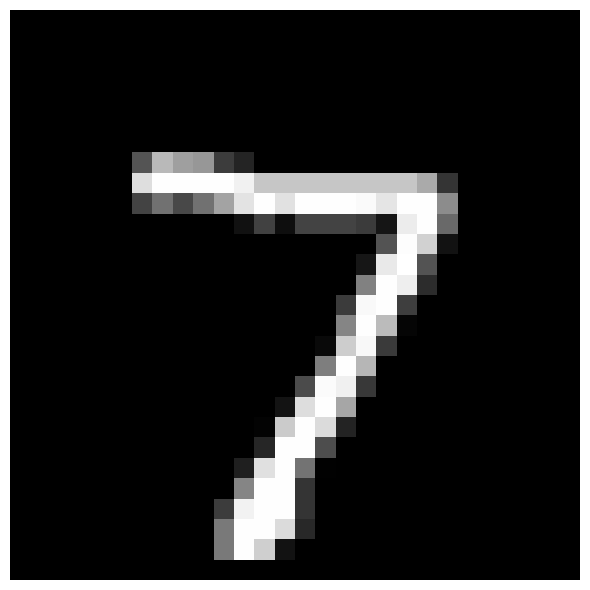

In [21]:
visualize_digit(xs[0])

In [39]:
ypred

[[Value(data = 1.7154598149992344),
  Value(data = 0.5151862858150189),
  Value(data = -0.44837763002004244),
  Value(data = -0.44837763002004255),
  Value(data = -0.21791808206615926),
  Value(data = 0.5151862858150194),
  Value(data = 0.5151862858150194),
  Value(data = 0.5151862858150198),
  Value(data = -3.7570033433737513),
  Value(data = 1.715459814999235)],
 [Value(data = 1.7154598149992344),
  Value(data = 0.5151862858150189),
  Value(data = -0.44837763002004244),
  Value(data = -0.44837763002004255),
  Value(data = -0.21791808206615926),
  Value(data = 0.5151862858150194),
  Value(data = 0.5151862858150194),
  Value(data = 0.5151862858150198),
  Value(data = -3.7570033433737513),
  Value(data = 1.715459814999235)],
 [Value(data = 1.7154598149992344),
  Value(data = 0.5151862858150189),
  Value(data = -0.44837763002004244),
  Value(data = -0.44837763002004255),
  Value(data = -0.21791808206615926),
  Value(data = 0.5151862858150194),
  Value(data = 0.5151862858150194),
  Value(